In [ ]:
# TRY THE SAME PART WITH MERGING THE DATA IN A BETTER WAY

## READ THE REQUIRED TWO TABLES 

In [1]:
import pandas as pd

In [2]:
data_train = pd.read_csv("C:/Users/mural/MDS/BLOCK6/DATA586/NEW/HDFS_1 (1)/HDFS_100k.log_structured.csv")
data_train.head(2)

,LineId,Date,Time,Pid,Level,Component,Content,EventId,EventTemplate
0,1,81109,12:00:00 AM,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>
1,2,81109,1:00:00 AM,35,INFO,dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...,E22,BLOCK* NameSystem.allocateBlock:<*>


In [3]:
data_label= pd.read_csv("C:/Users/mural/MDS/BLOCK6/DATA586/NEW/HDFS_1 (1)/anomaly_label.csv")
data_label.head(2)

,BlockId,Label
0,blk_-1608999687919862906,Normal
1,blk_7503483334202473044,Normal


#### WE SHOULD NOW EXTRACT THE BLOCKIDS FROM BOTH OF THEM AND MERGE THE DATAFRAME:

In [5]:
data_train['Content']

0         Receiving block blk_-1608999687919862906 src: ...
1         BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...
2         Receiving block blk_-1608999687919862906 src: ...
3         Receiving block blk_-1608999687919862906 src: ...
4         PacketResponder 1 for block blk_-1608999687919...
                                ...                        
104810    Verification succeeded for blk_-87387097785867...
104811    Verification succeeded for blk_642047611142564...
104812    Verification succeeded for blk_-23823897510323...
104813    Verification succeeded for blk_485603173001003...
104814    Verification succeeded for blk_-49047501208105...
Name: Content, Length: 104815, dtype: object

In [41]:
data_train['id']=data_train['Content'].str.extract(r'(?:blk_|blk_-)(\d+)')

In [40]:
# moving throug the data the regex we used are correct:

In [42]:
data_label['id']= data_label['BlockId'].str.extract(r'(?:blk_|blk_-)(\d+)')

#### Join both of these tables together

In [43]:
len(data_label)

575061

In [44]:
len(data_train)

104815

In [47]:
train = data_train[['id','EventId']]

In [57]:
# We should perform a left join from the values:
data = pd.merge(train, data_label, on='id', how='left')
data

,id,EventId,BlockId,Label
0,1608999687919862906,E5,blk_-1608999687919862906,Normal
1,1608999687919862906,E22,blk_-1608999687919862906,Normal
2,1608999687919862906,E5,blk_-1608999687919862906,Normal
3,1608999687919862906,E5,blk_-1608999687919862906,Normal
4,1608999687919862906,E11,blk_-1608999687919862906,Normal
...,...,...,...,...
104810,8738709778586756237,E2,blk_-8738709778586756237,Normal
104811,6420476111425645508,E2,blk_6420476111425645508,Normal
104812,2382389751032389929,E2,blk_-2382389751032389929,Normal
104813,4856031730010032819,E2,blk_4856031730010032819,Normal


### AGGREGRATE THE VALUES FOR THE EVENT IDS:

In [51]:
data_agg = data.groupby('BlockId')['EventId'].apply(lambda x: "[%s]" % ', '.join(x))
type(data_agg)

pandas.core.series.Series

In [52]:
data_agg = data_agg.to_frame()
data_agg = data_agg.reset_index()

In [53]:
data_agg

,BlockId,EventId
0,blk_-1001553972418305662,"[E22, E5, E5, E5, E26, E26, E11, E9, E11, E9, ..."
1,blk_-1010952805175971965,"[E22, E5, E5, E5, E26, E26, E26, E11, E9, E11,..."
2,blk_-1011482868748761910,"[E22, E5, E5, E5, E26, E26, E11, E9, E11, E9, ..."
3,blk_-1011537904811654030,"[E5, E22, E5, E5, E11, E9, E11, E9, E11, E9, E..."
4,blk_-1015291919896450721,"[E22, E5, E5, E5, E26, E9, E11, E9, E26, E26, ..."
...,...,...
7935,blk_989409441141247289,"[E22, E5, E5, E5, E26, E26, E26, E11, E9, E11,..."
7936,blk_989757635324841895,"[E5, E22, E5, E5, E11, E9, E11, E9, E11, E9, E..."
7937,blk_992037777600190687,"[E22, E5, E5, E5, E26, E26, E11, E9, E11, E9, ..."
7938,blk_993316727245644324,"[E22, E5, E5, E5, E11, E9, E11, E9, E11, E9, E..."


In [62]:
data_agg = pd.merge(data_agg, data[['BlockId','Label']], on= 'BlockId', how='inner').drop_duplicates()

#### FEATURE EXTRACTION WORK

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [55]:
vec = TfidfVectorizer()
x_train_features = vec.fit_transform(data_agg['EventId'])

In [63]:
y_train_features = data_agg['Label']

#### CREATING THE TEST TRAIN SPLIT

In [100]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

In [85]:
X_train, X_test, y_train, y_test = train_test_split(x_train_features, y_train_features, test_size=0.20)

In [86]:
DT = DecisionTreeClassifier()
DT = DT.fit(X_train.toarray(), y_train)

In [87]:
DT.score(X_train.toarray(),y_train)

0.979691435768262

In [88]:
y_pred = DT.predict(X_test.toarray())
print("Accuracy is",metrics.accuracy_score(y_test, y_pred))

Accuracy is 0.9792191435768262


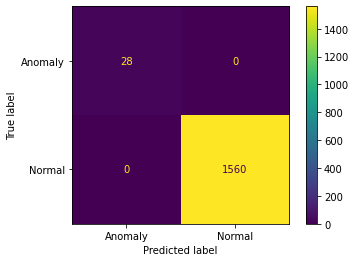

In [102]:
plot_confusion_matrix(DT, X_test, y_pred) 

#### DOING THE SAME WITH ANOTHER CALSSIFIER

In [81]:
from sklearn.naive_bayes import GaussianNB

In [89]:
NB = GaussianNB()
NB.fit(X_train.toarray(),y_train)

GaussianNB()

In [90]:
NB.score(X_train.toarray(),y_train)

0.9793765743073047

In [91]:
y_pred_NB = NB.predict(X_test.toarray())
print("Accuracy is",metrics.accuracy_score(y_test, y_pred_NB))

Accuracy is 0.9792191435768262


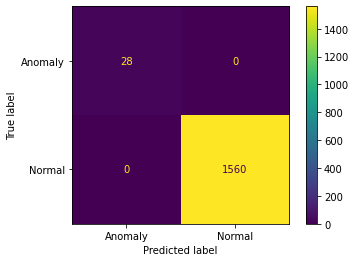

In [105]:
plot_confusion_matrix(DT, X_test, y_pred_NB) 

#### TRYING WITH ANOTHER CLASSIFIER

In [94]:
from xgboost import XGBClassifier

In [96]:
model = XGBClassifier()
model.fit(X_train.toarray(), y_train)

[11:10:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [97]:
model.score(X_train.toarray(),y_train)

0.979691435768262

In [98]:
y_pred_model = model.predict(X_test.toarray())
print("Accuracy is",metrics.accuracy_score(y_test, y_pred_model))

Accuracy is 0.9792191435768262
